# Dimensionality Reduction

Many Machine Learning problems involve thousands or even millions of features for each training instance. Not only do all these features make training extremely slow, but they can also make it much harder to find a good solution. This problem is often referred to as the **curse of dimensionality**.

Fortunately, in real-world problems, it is often possible **to reduce the number of features considerably**, turning an intractable problem into a tractable one. For example, consider the MNIST images, the pixels on the image borders are almost always white, so we could completely drop these pixels from the training set without losing much information. Additionally, two neighboring pixels are often highly correlated: if we merge them into a single pixel (e.g., by taking the mean of the two pixel intensities), we will not lose much information.

Reducing dimensionality does cause some information loss, so even though it will speed up training, it may make our system perform slightly worse. It also makes the pipelines more complex and harder to maintain. 

Dimensionality reduction is also extremely useful for **data visualization**. Reducing the number of dimensions down to two (or three) makes it possible to plot a condensed view of a high-dimensional training set on a graph and often gain some important insights by visually detecting patterns, such as clusters.

In [60]:
import sklearn
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

np.random.seed(42)

import warnings
warnings.filterwarnings('ignore')

## The Curse of Dimensionality
We are so used to living in three dimensions that our intuition fails us when we try to imagine a high-dimensional space. Even a basic 4D hypercube is incredibly hard to picture in our minds, let alone a 200-dimensional ellipsoid bent in a 1,000 dimensional space:

<img src="images/n-dimensions.png" width="600">

It turns out that many things behave very differently in high-dimensional space. For example, if you pick a random point in a unit square (a 1 × 1 square), it will have only about a 0.4% chance of being located less than 0.001 from a border (in other words, it is very unlikely that a random point will be “extreme” along any dimension). But in a 10,000-dimensional unit hypercube, this probability is greater than 99.999999%. Most points in a high-dimensional hypercube are very close to the border. Fun fact: anyone you know is probably an extremist in at least one dimension (e.g., how much sugar they put in their coffee), if you consider enough dimensions.

Here is a more troublesome difference: if you pick two points randomly in a unit square, the distance between these two points will be, on average, roughly 0.52. If you pick two random points in a unit 3D cube, the average distance will be roughly 0.66. But what about two points picked randomly in a 1,000,000-dimensional hypercube? The average distance will be about 408.25! This is counterintuitive: how can two points be so far apart when they both lie within the same unit hypercube? Well, there’s just plenty of space in high dimensions. As a result, high-dimensional datasets are at risk of being **very sparse**: most training instances are likely to be far away from each other. This also means that a new instance will likely be far away from any training instance, making predictions much less reliable than in lower
dimensions, since they will be based on much larger extrapolations. 

One solution to the curse of dimensionality could be to increase the size of the training set to reach a sufficient density of training instances. Unfortunately, in practice, the number of training instances required to reach a given density grows exponentially with the number of dimensions. 

https://colab.research.google.com/github/rabbanyk/comp551-notebooks/blob/master/CurseOfDimensionality.ipynb


### Projection

In most real-world problems, training instances are not spread out uniformly across all dimensions. Many features are almost constant, while others are highly correlated. As a result, all training instances lie within (or close to) a much lower-dimensional subspace of the high-dimensional space. 

Next figure shows a 3D dataset represented by circles. Notice that all training instances lie close to a plane: this is a lowerdimensional (2D) subspace of the high-dimensional (3D) space. If we project every training instance perpendicularly onto this subspace, we get a new 2D dataset. We have just reduced the dataset’s dimensionality from 3D to 2D. Note that the axes correspond to new features $z_1$ and $Z_2$ (the coordinates of the projections on the plane).

<img src="images/projection_1.png" width="300"> <img src="images/projection_2.png" width="300">


However, projection is not always the best approach to dimensionalityreduction. In many cases the subspace may twist and turn, such as in the famous [**Swiss roll toy dataset**](http://people.cs.uchicago.edu/~dinoj/manifold/swissroll.html):

In [61]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

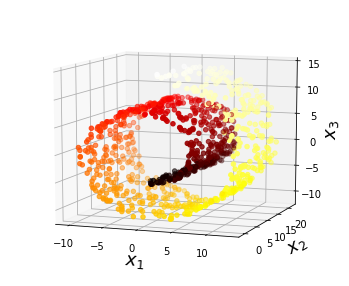

In [62]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))

ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

Simply projecting onto a plane (e.g. by dropping $x_3$) would squash different layers together, as shown on the first figure. What we really want is to unroll it to obtain the 2D dataset on the second:

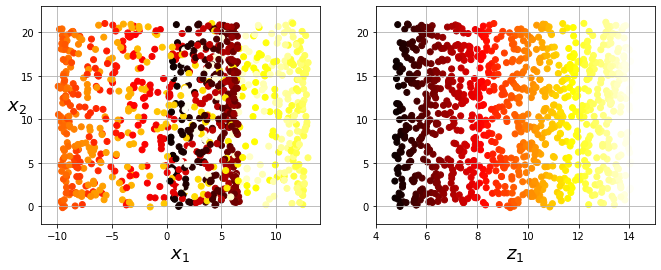

In [63]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

### Manifold Learning

The Swiss roll is an example of a 2D manifold. Put simply, a 2D manifold is a 2D shape that can be bent and twisted in a higher-dimensional space. More generally, a **d-dimensional manifold** is a part of an n-dimensional space (where d < n) that locally resembles a d-dimensional hyperplane. In the case of the Swiss roll ($d=2$ and $n=3$), it locally resembles a 2D plane, but it is rolled in the third dimension.

Many dimensionality reduction algorithms work by modeling the manifold on which the training instances lie; this is called **Manifold Learning**. It relies on the **manifold assumption**: most real-world high-dimensional datasets lie close to a much lower-dimensional manifold, which is very often empirically observed.

Think about the MNIST dataset: all handwritten digit images have some similarities:  they are made of connected lines, the borders are white, and they are more or less centered. If you randomly generated images, only a small fraction of them would look like handwritten digits. In other words, the degrees of freedom to create a digit image are dramatically lower than the degrees of freedom allowed to generate any image. These constraints tend to squeeze the dataset into a lower dimensional manifold.

The manifold assumption is often accompanied by another implicit assumption: that the task at hand will be simpler if expressed in the lower-dimensional space of the manifold. However, this assumption does not always hold. For example, in the next figure, the decision boundary is located at $x=5$, which looks very simple in the original 3D space (a vertical plane), but it looks more complex in the unrolled manifold (a collection of four independent line segments):

<img src="images/manifold.png" width="600">

Now you we have a good sense of what the curse of dimensionality is and how dimensionality reduction algorithms can fight it, especially when the manifold assumption holds.

## Principal Component Analysis

**Principal Component Analysis (PCA)** is the most popular dimensionality reduction algorithm. First it identifies the hyperplane that lies closest to the data, and then it projects the data onto it.

We need to choose the right hyperplane. For example, next figure shows a simple 2D dataset and the projections on three axes (1D hyperplanes):

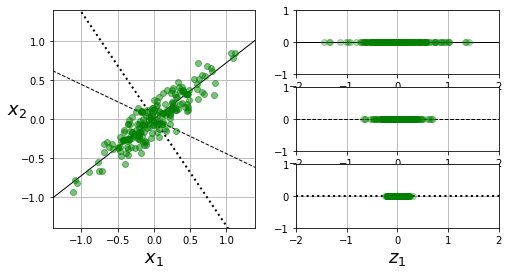

In [64]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))

plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "go", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "go", alpha=0.3)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "go", alpha=0.3)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "go", alpha=0.3)
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

As you can see, the projection onto the solid line preserves the maximum variance. It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. This is the rather simple idea behind PCA.

PCA identifies the axis that accounts for the largest amount of variance in the training set. It also finds a second axis, orthogonal to the first one, that accounts for the largest amount of remaining variance. If it were a higher dimensional dataset, PCA would also find a third axis, orthogonal to both previous axes, and a fourth, a fifth, and so on—as many axes as the number of dimensions in the dataset.

The $i^{th}$ axis is called the **$i^{th}$ principal component** of the data. 

How can we find the principal components of a training set? Luckily, there is a standard matrix factorization technique called **Singular Value Decomposition (SVD)** that can decompose the training set matrix $X$ into the matrix multiplication of three matrices $U$ $\Sigma$ $V^T$, where $V$ contains the unit
vectors that define all the principal components that we are looking for.

The following Python code uses NumPy’s **svd()** function to obtain all the principal components of the training set, then extracts the two unit vectors that define the first two PCs and plot them.

[-0.79643751 -0.60472084]
[-0.60472084  0.79643751]


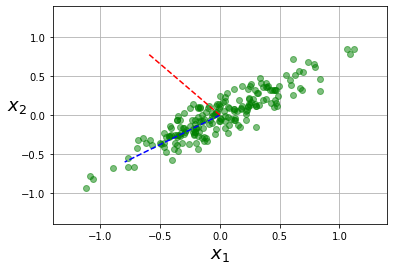

In [65]:
U, s, Vt = np.linalg.svd(X)

c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

print(c1)
print(c2)

plt.plot(X[:, 0], X[:, 1], "go", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.plot([0, c1[0]],[0, c1[1]], "b--" )
plt.plot([0, c2[0]],[0, c2[1]], "r--")
plt.grid(True)

PCA assumes that the dataset is centered around the origin, don’t forget to center the data first.

Once we have identified all the principal components, we can reduce the dimensionality of the dataset down to $d$ dimensions by projecting the dataser onto the hyperplane defined by the first $d$ principal components. Selecting this hyperplane ensures that the projection will preserve as much variance as possible. 

To project the training set onto the hyperplane and obtain a reduced dataset $X_{d-proj}$ of dimensionality $d$, we need to compute the matrix multiplication of the training set matrix $X$ by the matrix $W_d$, defined as the matrix containing the first $d$ columns of $V$

$X_{d-proj} = X W_d$


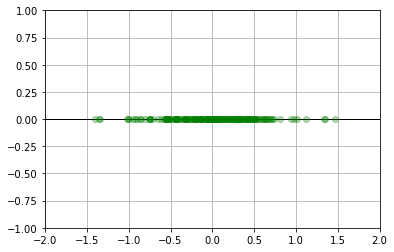

In [147]:
W1 = Vt.T[:, :1]
X1D = X.dot(W1)

plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X1D[:, 0], np.zeros(m), "go", alpha=0.3)
plt.axis([-2, 2, -1, 1])
plt.grid(True)

Scikit-Learn’s **PCA class** uses SVD decomposition to implement PCA (note that it automatically takes care of centering the data):

In [148]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

After fitting the PCA transformer to the dataset, its **components_** attribute holds the transpose of $W_d$.

In [149]:
print(pca.components_)

[[-0.79644131 -0.60471583]
 [ 0.60471583 -0.79644131]]


Another useful piece of information is the **explained_variance_ratio_** variable, which indicates the proportion of the dataset’s variance that lies along each principal component.

In [150]:
print(pca.explained_variance_ratio_)

[0.95369864 0.04630136]


This output tells us that 95% of the dataset’s variance lies along the first PC. This leaves less than 4.6% for the second PC, so it is reasonable to assume that the second PC probably carries little information.

### From Scratch
As a first step, we’ll need to translate the data so that each dimension has mean
0

In [110]:
import sys; sys.path.insert(0, '..')
from typing import List, Dict
from scratch.linear_algebra import Vector, vector_mean, scalar_multiply, subtract, magnitude, dot
import tqdm

def de_mean(data: List[Vector]) -> List[Vector]:
    """Recenters the data to have mean 0 in every dimension"""
    mean = vector_mean(data)
    return [subtract(vector, mean) for vector in data]

Now, given a de-meaned matrix $X$, we can ask which is the direction that captures the greatest variance in the data. Specifically, given a direction $d$ (a vector of magnitude 1), each row $x$ in the matrix extends $dot(x,d)$ in the $d$ direction. And every nonzero vector $w$ determines a direction if we rescale it to have magnitude 1

In [111]:
def direction(w: Vector) -> Vector:
    mag = magnitude(w)
    return [w_i / mag for w_i in w]

Therefore, given a nonzero vector $w$, we can compute the variance of our dataset
in the direction determined by $w$:

In [112]:
def directional_variance(data: List[Vector], w: Vector) -> float:
    """ Returns the variance of x in the direction of w """
    w_dir = direction(w)
    return sum(dot(v, w_dir) ** 2 for v in data)

We’d like to find the direction that maximizes this variance. We can do this using gradient descent, as soon as we have the gradient function.

In [113]:
def directional_variance_gradient(data: List[Vector], w: Vector) -> Vector:
    """ The gradient of directional variance with respect to w """
    w_dir = direction(w)
    return [sum(2 * dot(v, w_dir) * v[i] for v in data)
            for i in range(len(w))]

And now the first principal component that we have is just the direction that maximizes the directional_variance function:

In [114]:
from scratch.gradient_descent import gradient_step

def first_principal_component(data: List[Vector], n: int = 100, step_size: float = 0.1) -> Vector:
    # Start with a random guess
    guess = [1.0 for _ in data[0]]
    with tqdm.trange(n) as t:
        for _ in t:
            dv = directional_variance(data, guess)
            gradient = directional_variance_gradient(data, guess)
            guess = gradient_step(guess, gradient, step_size)
            t.set_description(f"dv: {dv:.3f}")
    return direction(guess)

On the de-meaned dataset, this returns a direction which does appear to capture the primary axis along which our data varies:

dv: 48.480: 100%|██████████| 100/100 [00:00<00:00, 1055.81it/s]


[0.7962389330654722, 0.6049822819477925]


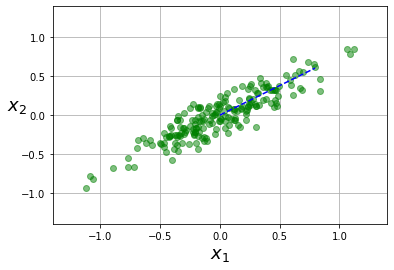

In [134]:
X_demeaned = de_mean(X.tolist());
fpc = first_principal_component(X_demeaned)

print(fpc)

plt.plot(X[:, 0], X[:, 1], "go", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.plot([0, fpc[0]],[0, fpc[1]], "b--" )
plt.grid(True)

Once we’ve found the direction that’s the first principal component, we can
project our data onto it to find the values of that component.

In [124]:
def project(v: Vector, w: Vector) -> Vector:
    """return the projection of v onto the direction w"""
    projection_length = dot(v, w)
    return scalar_multiply(projection_length, w)

def project_data(data: List[Vector], w: Vector) -> List[Vector]:
    return [project(v, w) for v in data]

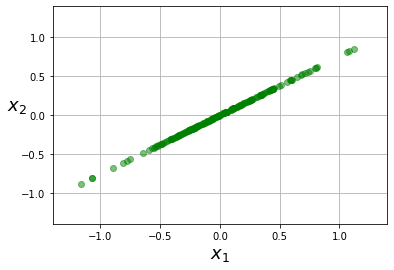

In [133]:
X_projected = np.array(project_data(X.tolist(), fpc))

plt.plot(X_projected[:, 0], X_projected[:, 1], "go", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

If we want to find further components, we first remove the projections from the
data:

In [131]:
def remove_projection_from_vector(v: Vector, w: Vector) -> Vector:
    """projects v onto w and subtracts the result from v"""
    return subtract(v, project(v, w))

def remove_projection(data: List[Vector], w: Vector) -> List[Vector]:
    return [remove_projection_from_vector(v, w) for v in data]

dv: 2.351: 100%|██████████| 100/100 [00:00<00:00, 1040.10it/s]


[-0.5794932991474917, 0.8149770035057158]


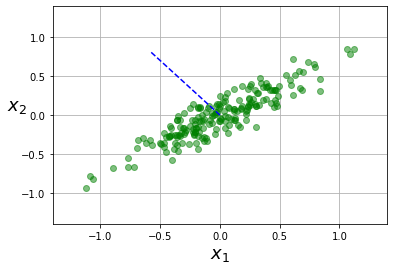

In [137]:
X_demenead_2 = remove_projection(X_demeaned, fpc)

spc = first_principal_component(X_demenead_2)

print(spc)

plt.plot(X[:, 0], X[:, 1], "go", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.plot([0, spc[0]],[0, spc[1]], "b--" )
plt.grid(True)

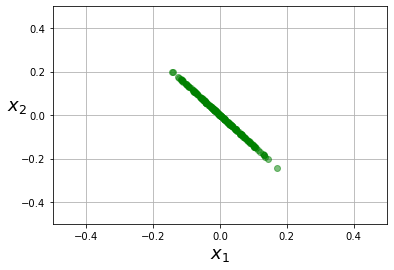

In [141]:
X_projected_2 = np.array(project_data(X.tolist(), spc))

plt.plot(X_projected_2[:, 0], X_projected_2[:, 1], "go", alpha=0.5)
plt.axis([-0.5, 0.5, -0.5, 0.5])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

Because this example dataset is only two-dimensional, after we remove the first
component, what’s left will be effectively one-dimensional. On a higher-dimensional dataset, we can iteratively find as many components as we want:

In [159]:
def my_pca(data: List[Vector], num_components: int) -> List[Vector]:
    components: List[Vector] = []
    for _ in range(num_components):
        component = first_principal_component(data)
        components.append(component)
        data = remove_projection(data, component)
    return components

We can then transform our data into the lower-dimensional space spanned by
the components:

In [ ]:
def transform_vector(v: Vector, components: List[Vector]) -> Vector:
    return [dot(v, w) for w in components]

def transform(data: List[Vector], components: List[Vector]) -> List[Vector]:
    return [transform_vector(v, components) for v in data]

### Choosing the Right Number of Dimensions

Instead of arbitrarily choosing the number of dimensions to reduce down to, it is simpler to choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%). Unless, of course, you are reducing dimensionality for data visualization, in that case you will want to reduce the dimensionality down to 2 or 3.

Instead of specifying the number of principal components we want to preserve, we can set **n_components** to be a float
between 0.0 and 1.0, indicating the ratio of variance we wish to preserve:

In [151]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X)

Another option is to plot the explained variance as a function of the number of dimensions. There will usually be an elbow in the curve, where the explained variance stops
growing fast.

## Reducing on MNIST

After dimensionality reduction, the training set takes up much less space. As an example, we can try to apply PCA to the MNIST dataset while preserving 95% of its variance. 

In [152]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

In [153]:
from sklearn.model_selection import train_test_split

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [154]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(d);

154


We find that the number of features is around 150, instead of the original 784 features. So, while most of the variance is preserved, the dataset is now less than 20% of its original size. This is a reasonable compression ratio, and we can see how this size reduction can speed up a classification algorithm (such as an SVM
classifier) tremendously.

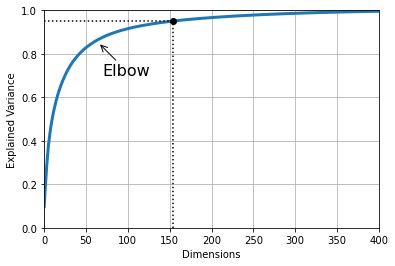

In [155]:
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

It is possible to decompress the reduced dataset back to 784 dimensions by applying the inverse transformation of the PCA projection (**inverse_transform()** method). This won’t give us back the original data, since the projection lost a bit of information (within the 5% variance that was dropped), but it will likely be close to the original data. The mean squared distance between the original data and the reconstructed data is called the **reconstruction error**.

In [156]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

Text(0.5, 1.0, 'Compressed')

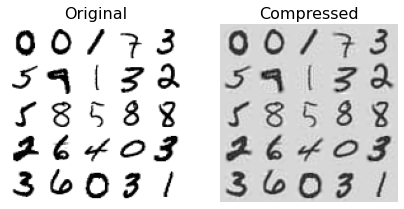

In [157]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")
    
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

## Optimized PCA

### Randomized PCA

If we set the **svd_solver** hyperparameter to "randomized", Scikit-Learn uses a stochastic algorithm called **Randomized PCA** that quickly finds an approximation of the first $d$ principal components. Its computational complexity is 

$O(m \times d^2) + O(d^3)$

instead of 

$O(m \times n^3) + O(n^3)$ 

for the full SVD approach, so it is dramatically faster than full SVD when $d$ is much smaller than $n$

In [161]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced_pca = rnd_pca.fit_transform(X_train)

### Incremental PCA

One problem with the implementation of PCA is that it require the whole training set to fit in memory in order for the algorithm to run. Fortunately, the **Incremental PCA (IPCA)** algorithm has been developed. It allow to split the training set into mini-batches and feed an PCA algorithm one mini-batch at a time. This is useful for large training sets and for applying PCA online (i.e., on the fly, as new instances arrive).

In [163]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="")
    inc_pca.partial_fit(X_batch)

X_reduced_inc = inc_pca.transform(X_train)

....................................................................................................

Let's compare the results of transforming MNIST using regular PCA and incremental PCA. First, the means are equal. But the results are not exactly identical. Incremental PCA gives a very good approximate solution, but it's not perfect.

In [164]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [165]:
np.allclose(X_reduced, X_reduced_inc)

False

### Time comparison
Let's time regular PCA against Incremental PCA and Randomized PCA, for various number of principal components:

In [22]:
import time

In [23]:
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    regular_pca = PCA(n_components=n_components, svd_solver="full")
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, svd_solver="randomized")

    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print("    {}: {:.1f} seconds".format(pca, t2 - t1))

n_components = 2
    PCA(n_components=2, svd_solver='full'): 2.9 seconds
    IncrementalPCA(batch_size=500, n_components=2): 4.9 seconds
    PCA(n_components=2, svd_solver='randomized'): 0.6 seconds
n_components = 10
    PCA(n_components=10, svd_solver='full'): 2.2 seconds
    IncrementalPCA(batch_size=500, n_components=10): 5.0 seconds
    PCA(n_components=10, svd_solver='randomized'): 0.8 seconds
n_components = 154
    PCA(n_components=154, svd_solver='full'): 2.4 seconds
    IncrementalPCA(batch_size=500, n_components=154): 6.4 seconds
    PCA(n_components=154, svd_solver='randomized'): 1.8 seconds


Now let's compare PCA and Randomized PCA for datasets of different sizes (number of instances):

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

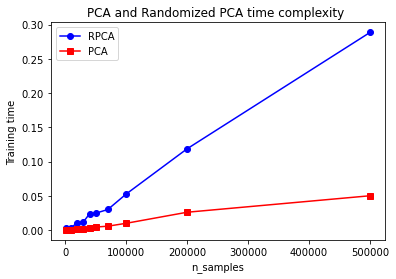

In [24]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    
    pca = PCA(n_components = 2, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

And now let's compare their performance on datasets of 2,000 instances with various numbers of features:

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

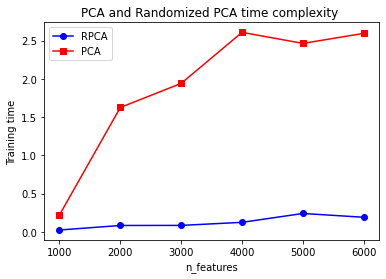

In [25]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    
    X = np.random.randn(2000, n_features)
    
    pca = PCA(n_components = 2, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    
    pca = PCA(n_components = 2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

## Kernel PCA

The **kernel "trick"**, used in nonlinear classification and regression with Support Vector Machines (SVM), can be applied to PCA. The main idea is to map instances into a very high-dimensional space (called the feature space) and notice that a linear decision boundary in this high-dimensional feature space corresponds to a complex nonlinear decision boundary in the original space.

In PCA, this makes possible to perform complex nonlinear projections for dimensionality reduction and this is called **Kernel PCA (kPCA)** [Bernhard Schölkopf. **Kernel Principal Component Analysis** Lecture Notes in
Computer Science](https://people.eecs.berkeley.edu/~wainwrig/stat241b/scholkopf_kernel.pdf)

The following code uses Scikit-Learn’s **KernelPCA class** to perform kPCA
on the Swiss roll to reduced it to two dimensions using a linear kernel (equivalent to simply using the PCA class), a Radial Basis Function kernel (RBF) and a
sigmoid kernel.

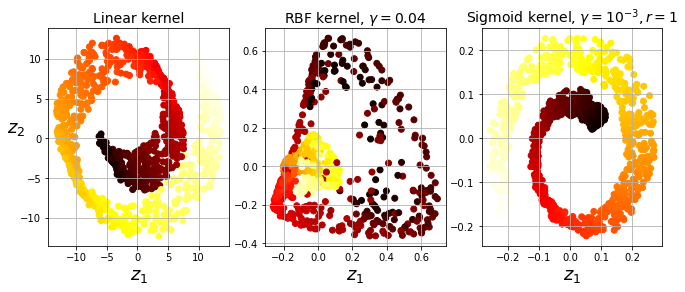

In [26]:
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
plt.show()

There is no obvious performance measure to help in selecting the best kernel and hyperparameter values. Dimensionality reduction is often a preparation step for a
supervised learning task (e.g., classification), so we can use grid search to select the kernel and hyperparameters that lead to the best performance on that task. 

The following code creates a two-step pipeline, first reducing dimensionality to two dimensions using kPCA, then applying Logistic Regression for classification. Then it uses GridSearchCV to find the best kernel and gamma value for kPCA in order to get the best classification accuracy at the end of the pipeline. Finally, the best kernel and hyperparameters are then available through the **best_params_** variable.

In [27]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression(solver="lbfgs"))
    ])

param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [28]:
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


Another approach is to select the kernel and hyperparameters that yield the lowest reconstruction error. However, reconstruction is not easy as with the linear case. Due to the kernel trik, the transformation from the original dataset (top left) to. the the resulting dataset after kPCA is mathematically equivalent to map the training set to an infinite-dimensional feature space then projecting the transformed training set down to 2D using linear PCA. If we invert the linear PCA step for a given instance in the reduced space, the reconstructed point would lie in feature space, not in the original space. Since the feature space is infinite dimensional, we cannot compute the reconstructed point, and therefore we cannot compute the true reconstruction error. Fortunately, it is possible to find a point in the original space that would map close to the reconstructed point. This point is called the **reconstruction pre-image**. Once you have this pre-image, we can measure its squared distance to the original instance and we can select the kernel and hyperparameters that minimize this reconstruction pre-image error.

<img src="images/kpca.png" width="600">

But how to get this reconstruction? One solution is to train a supervised regression model, with the projected instances as the training set and the original instances as the targets. Scikit-Learn will do this automatically if we set **fit_inverse_transform=True**

In [30]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

1.0542166884909727e-26

## Other techniques

There are many other dimensionality reduction techniques, several of which are available in Scikit-Learn. Here are some of the most popular ones.

### Locally Linear Embedding

**Locally Linear Embedding (LLE)** [Sam T. Roweis et al. **Nonlinear Dimensionality Reduction by Locally Linear Embedding** Science 290, 2000](https://www.robots.ox.ac.uk/~az/lectures/ml/lle.pdf) is another powerful nonlinear dimensionality reduction technique. It is a Manifold Learning technique that works by first measuring how each training instance linearly relates to its closest neighbors and then looking for a lowdimensional representation of the training set where these local relationships are best preserved. This approach makes it particularly good at unrolling twisted manifolds, especially when there is not too much noise.

The following code uses Scikit-Learn’s **LocallyLinearEmbedding class** to unroll the Swiss roll.

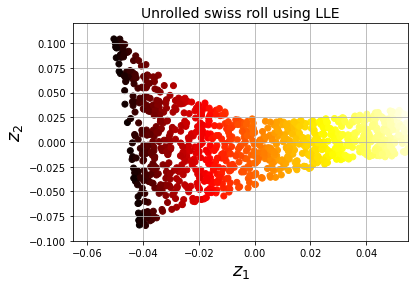

In [31]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()

### Random Projections

As its name suggests, projects the data to a lower-dimensional space using a random linear projection. This may sound crazy, but it turns out that such a random projection is actually very likely to preserve distances well, as was demonstrated mathematically by [Johnson-Lindenstrauss lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma). The quality of the dimensionality reduction depends on the number of instances and the target dimensionality, but surprisingly not on the initial dimensionality.

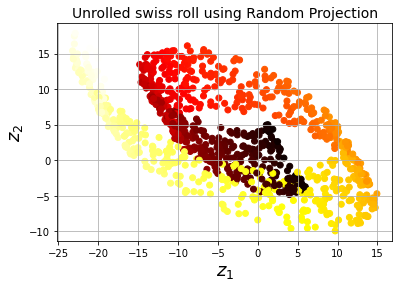

In [32]:
from sklearn import random_projection
transformer = random_projection.GaussianRandomProjection(n_components=2, eps=0.0001)
X_reduced = transformer.fit_transform(X)


plt.title("Unrolled swiss roll using Random Projection", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

plt.show()

### Multidimensional Scaling

Multidimensional Scaling (MDS) Reduces dimensionality while trying to preserve the distances between the instances.

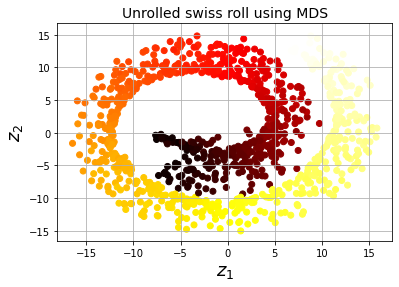

In [33]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced = mds.fit_transform(X)

plt.title("Unrolled swiss roll using MDS", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

plt.show()

### Isomap

Creates a graph by connecting each instance to its nearest neighbors, then reduces dimensionality while trying to preserve the geodesic distances between the instances.

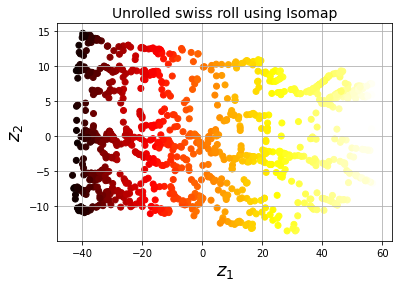

In [34]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced = isomap.fit_transform(X)

plt.title("Unrolled swiss roll using Isomap", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

plt.show()

### Distributed Stochastic Neighbor Embedding

t-Distributed Stochastic Neighbor Embedding (t-SNE) reduces dimensionality while trying to keep similar instances close and dissimilar instances apart. It is mostly used for visualization, in
particular to visualize clusters of instances in high-dimensional space.

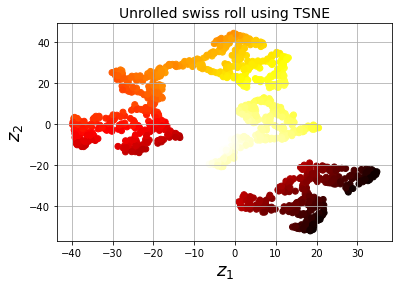

In [35]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

plt.title("Unrolled swiss roll using TSNE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.grid(True)

plt.show()

## Exercise

**1 - Load the MNIST dataset and split it into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing)**

In [36]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

**2 - Train a Random Forest classifier on the dataset and time how long it takes, then evaluate the resulting model on the test set**

In [141]:
import time
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

y_pred = rnd_clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Training took 38.18s
Accuracy:  0.9705


**3 - Next, use PCA to reduce the dataset's dimensionality, with an explained variance ratio of 95%**

In [142]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

**4 - Train a new Random Forest classifier on the reduced dataset and see how long it takes. Was training much faster?**

In [147]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

Training took 72.73s


Training is actually more than twice **slower** now! How can that be? Well, as we saw in this chapter, dimensionality reduction does not always lead to faster training time: it depends on the dataset, the model and the training algorithm.  

**5 - Next evaluate the classifier on the test set: how does it compare to the previous classifier?**

In [148]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
print("Accuracy: ", accuracy_score(y_test, y_pred))

0.9481

It is common for performance to drop slightly when reducing dimensionality, because we do lose some useful signal in the process. However, the performance drop is rather severe in this case. So PCA really did not help: it slowed down training and reduced performance.

**6 - Try a softmax classifier instead of a random forest classifier. What happens?**

In [153]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

y_pred = log_clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Training took 7.33s
Accuracy:  0.9255


In [154]:
log_clf2 = LogisticRegression(multi_class="multinomial", solver="lbfgs", random_state=42)

t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

print("Training took {:.2f}s".format(t1 - t0))

y_pred = log_clf.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred))

Training took 3.31s
Accuracy:  0.9255


Reducing dimensionality led to a 4× speedup and no drop in performance. So, PCA can give you a formidable speedup... but not always!

**7 - Use t-SNE to reduce the MNIST dataset down to two dimensions and plot the result using Matplotlib. You can use a scatterplot using 10 different colors to represent each image's target class.**

Dimensionality reduction on the full 60,000 images takes a very long time, so let's only do this on a random subset of 10,000 images:

In [155]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [156]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
t0 = time.time()
X_reduced = tsne.fit_transform(X)
t1 = time.time()

print("t-SNE took {:.1f}s.".format(t1 - t0))

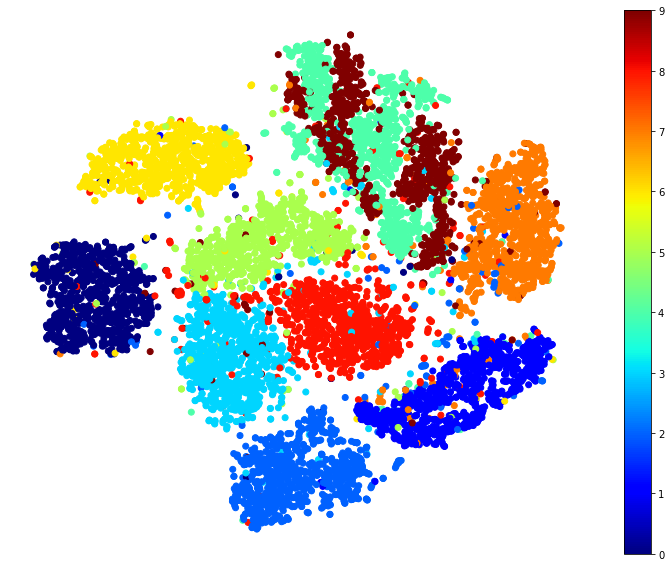

In [157]:
plt.figure(figsize=(13,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

This plot tells us which numbers are easily distinguishable from the others (e.g., 0s, 6s, and most 8s are rather well separated clusters), and it also tells us which numbers are often hard to distinguish (e.g., 4s and 9s, 5s and 3s, and so on).

Let's focus on digits 3 and 5, which seem to overlap a lot.

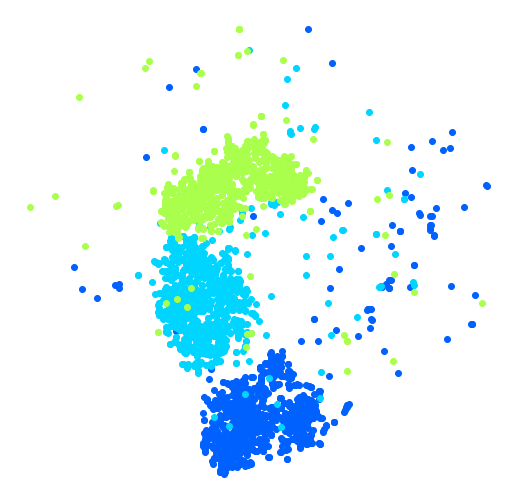

In [158]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Let's see if we can produce a nicer image by running t-SNE on these 3 digits:

In [159]:
idx = (y == 2) | (y == 3) | (y == 5) 
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

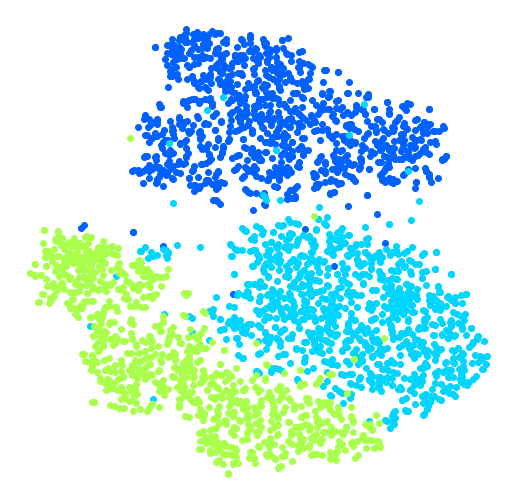

In [160]:
plt.figure(figsize=(9,9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0], X_subset_reduced[y_subset == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

Much better, now the clusters have far less overlap. But some 3s are all over the place. Plus, there are two distinct clusters of 2s, and also two distinct clusters of 5s. It would be nice if we could visualize a few digits from each cluster, to understand why this is the case. Let's do that now. 

**8 - Write colored digits at the location of each instance, or even plot scaled-down versions of the digit images themselves (if you plot all digits, the visualization will be too cluttered, so you should either draw a random sample or plot an instance only if no other instance has already been plotted at a close distance). You should get a nice visualization with well-separated clusters of digits**

Let's create a function that will draw a scatterplot plus write colored digits, with a minimum distance guaranteed between these digits. If the digit images are provided, they are plotted instead.

In [161]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # get current axes in current figure
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

Let's try it! First let's just write colored digits:

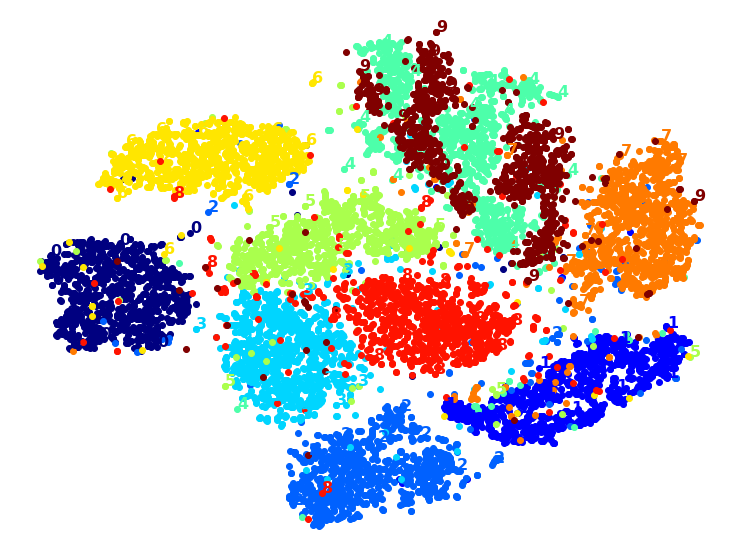

In [162]:
plot_digits(X_reduced, y)

Let's try with the digit images:

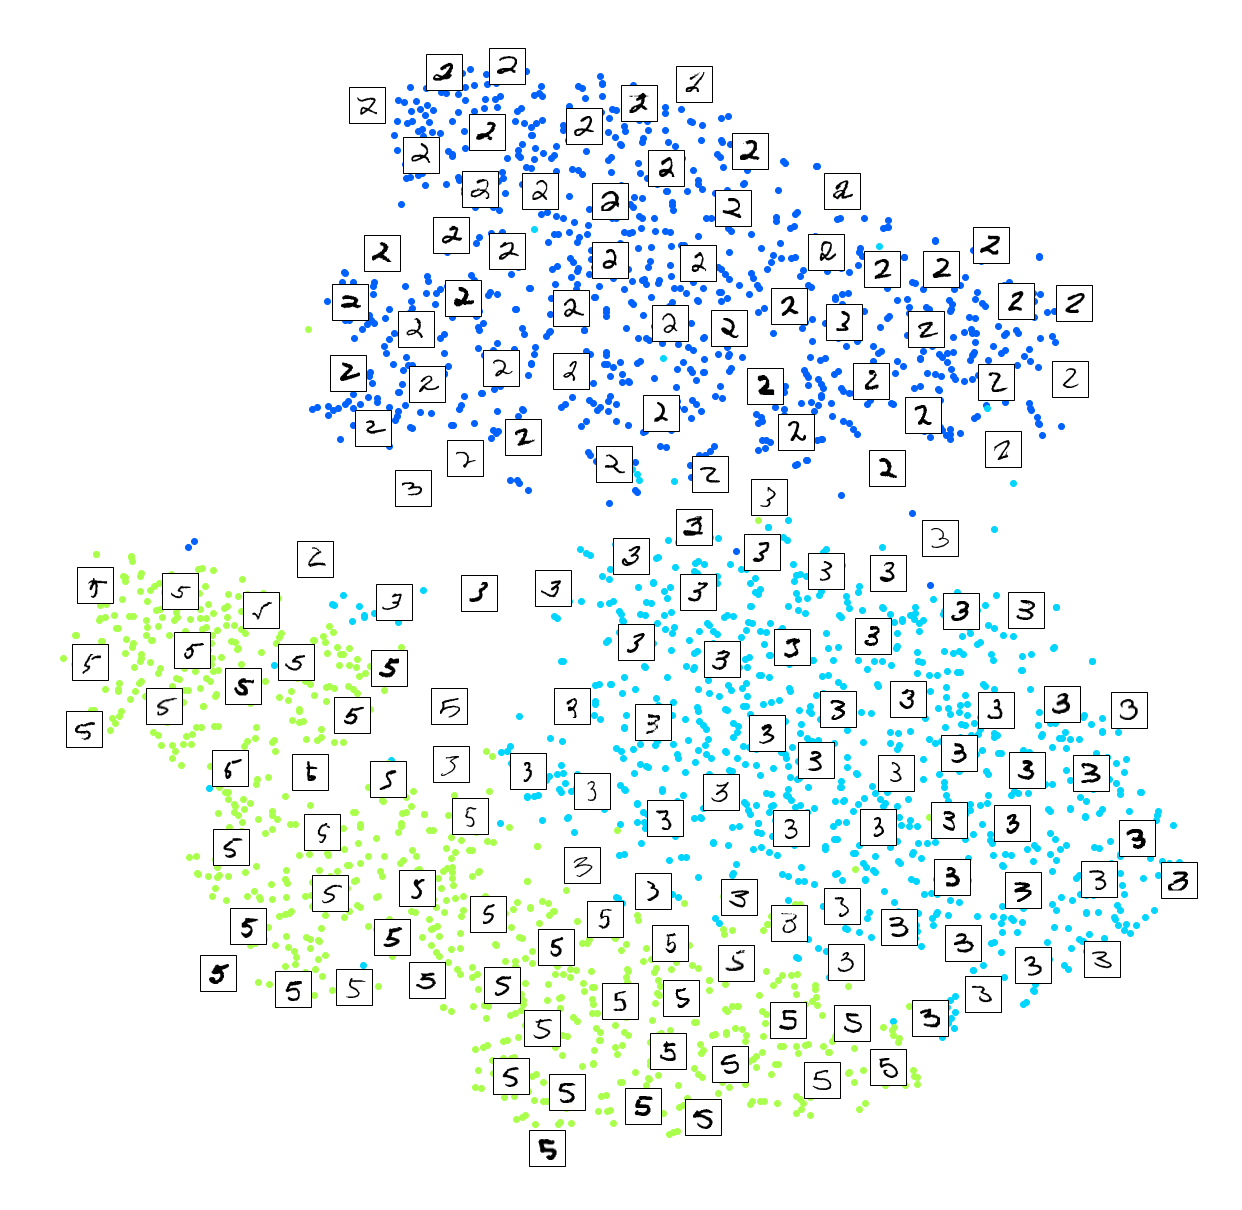

In [164]:
plot_digits(X_subset_reduced, y_subset, images=X_subset, figsize=(22, 22))

**9 - Try using other dimensionality reduction algorithms such as PCA, LLE, or MDS and compare the resulting visualizations**

Let's start with PCA. We will also time how long it takes:

PCA took 0.2s.


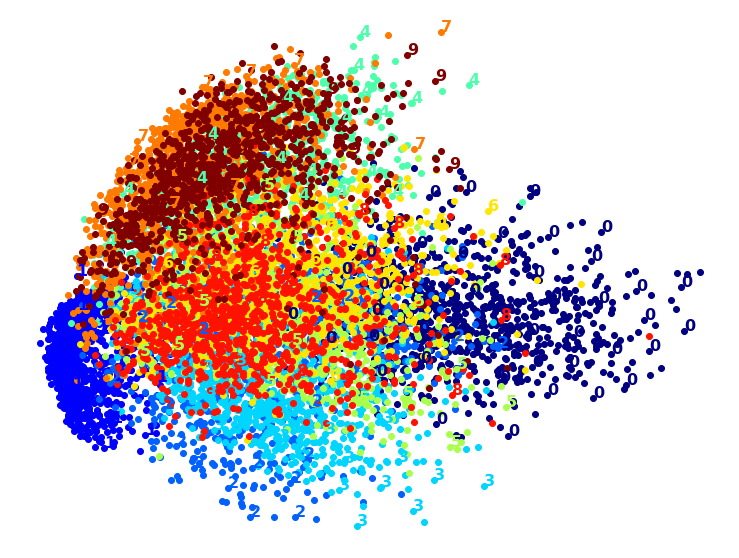

In [165]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

PCA is really fast, but although we do see a few clusters, there's way too much overlap

Let's try LLE:

LLE took 129.1s.


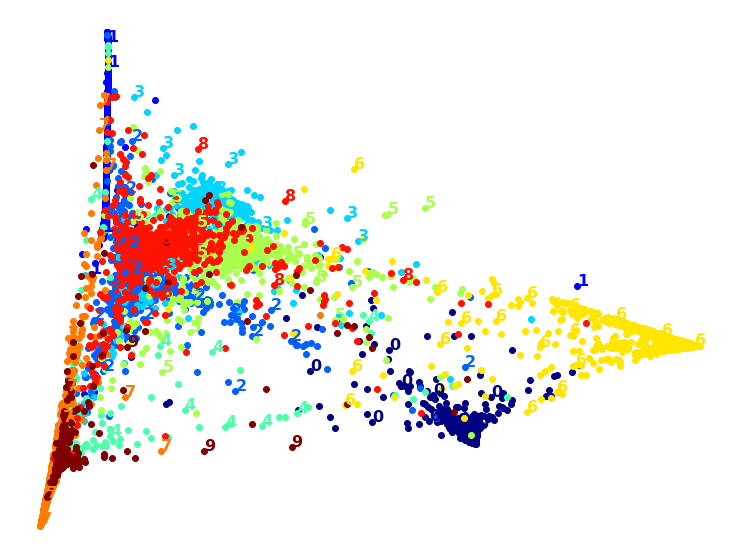

In [166]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

That took a while, and the result does not look too good. Let's see what happens if we apply PCA first, preserving 95% of the variance:

PCA+LLE took 27.9s.


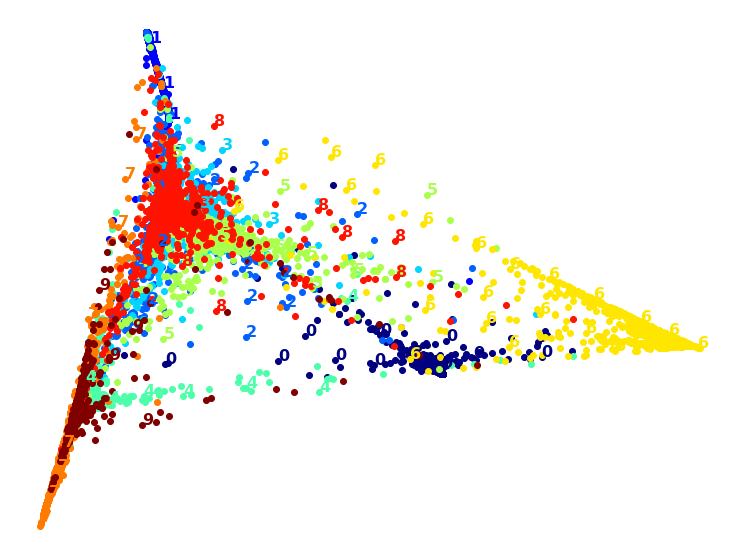

In [167]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("lle", LocallyLinearEmbedding(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()
print("PCA+LLE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

The result is more or less the same, but this time it was almost 4× faster.

Let's try MDS. It's much too long if we run it on 10,000 instances, so let's just try 2,000 for now:

MDS took 77.1s (on just 2,000 MNIST images instead of 10,000).


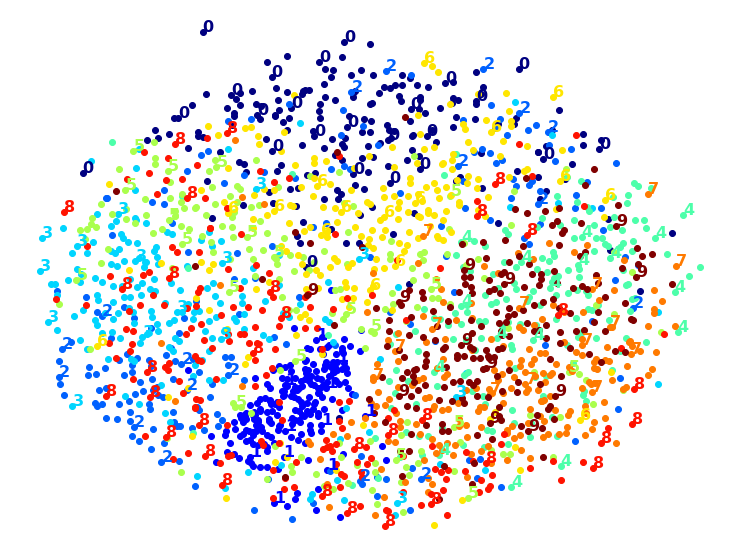

In [168]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS took {:.1f}s (on just 2,000 MNIST images instead of 10,000).".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

This does not look great, all clusters overlap too much.

Let's try LDA:

LDA took 1.0s.


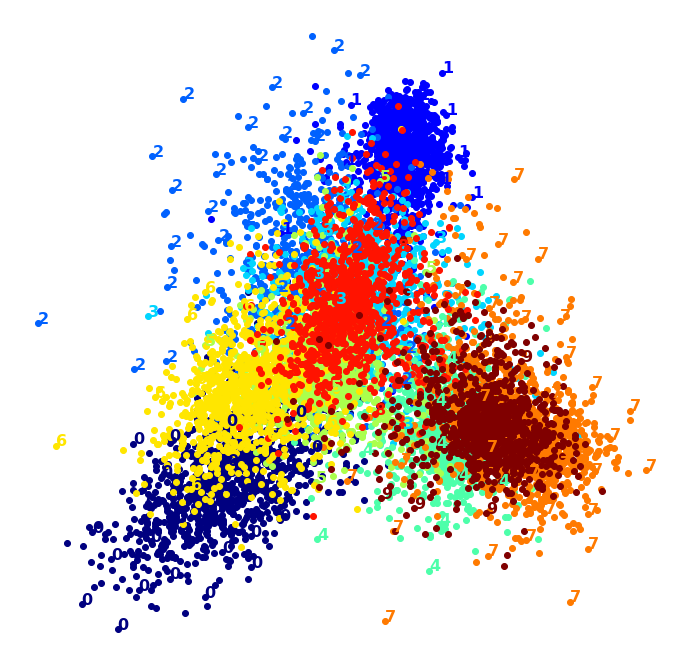

In [170]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("LDA took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

This one is very fast, and it looks nice at first, until you realize that several clusters overlap severely.

Well, it's pretty clear that t-SNE won this little competition, let's see if a bit of PCA can speed it up:

PCA+t-SNE took 55.3s.


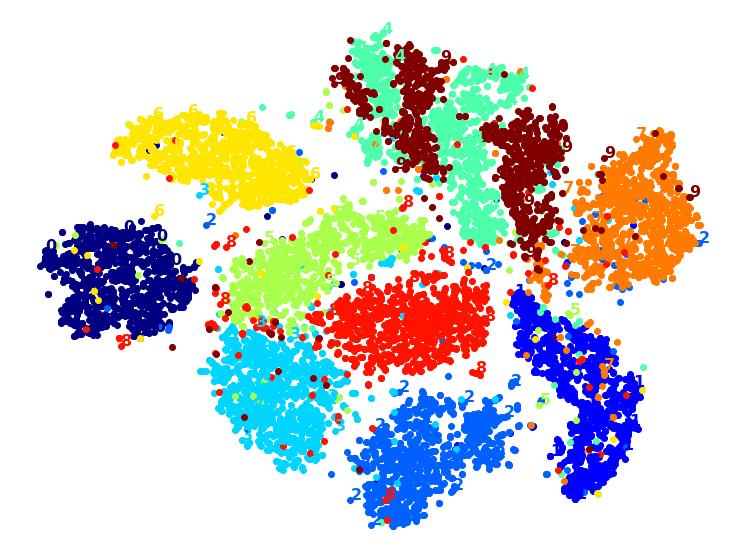

In [171]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("PCA+t-SNE took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()

Yes, PCA roughly gave us a speedup, without damaging the result.